# Text Segment Input Strategies
Different Input Strategies used for Language Model Input. Input of Language Model is pair ´(A,B)´ with ´A´ and ´B´ of type:
1. Sentence (S)
2. Title + Sentence (TS)
3. Title + Sentence + Date (TSD)
4. Sentence + Title + Date (STD)

*Sentence* is the extracted Sentence from News Article, *Title* is the News Article Title and *Date* is the publishing date of the article

## Set Input Strategy

In [28]:
input_strategy = 4

### Set annotation Preference in Detail
- Set whether to include news article headings or not
- If news headings are included, define separator (heading1 + separator + sentence1)
- Set whether to include timestamp of article
- If timestamp is used, define separator
- Set whether Title or Sentence should be at first position

In [29]:
# Strategy Presets
if input_strategy > 1:
    annotation_with_news_title = True
else:
    annotation_with_news_title = False
if input_strategy > 2:
    annotation_with_timestamp = True
else:
    annotation_with_timestamp = False
if input_strategy > 3:
    sentence_first = True
else:
    sentence_first = False

annotation_title_separator = ". "
annotation_timestamp_separator = " "

# Label Settings

In [30]:
# Labels definition - Without "Translation" (not used)
labels = ["none", "attribution", "causal", "conditional", "contrast", "description", "equivalence", "fulfillment", "identity", "purpose", "summary", "temporal"]

In [31]:
# Use subset of labels (defined below)
subset_labels = False

In [32]:
if subset_labels:
    labels = ["none", "causal", "contrast", "equivalence", "identity", "temporal", "others"]

# get Index of labels: if not found, take last label index ("others")
def index_of_label(val):
    global labels
    try:
        return labels.index(val)
    except ValueError:
        return len(labels) - 1

# General Settings

In [33]:
import_path = 'data/inception'
export_path = f'data/export/{input_strategy}/'


if subset_labels:
    export_path = f'data/export_subset/{input_strategy}/'

In [34]:
pair_matching_types = ["Random", "NSP", "Similarity"]

In [35]:
num_folds = 4

# Import Packages

## Install Package to write CAS XMI files
See https://github.com/dkpro/dkpro-cassis

In [36]:
import torch
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import glob
from pathlib import Path

In [37]:
Path(export_path).mkdir(parents=True, exist_ok=True)

# Import Project Data

## Load CAS

In [38]:
from cassis import *

with open(f'{import_path}/TypeSystem.xml', 'rb') as f:
    typesystem = load_typesystem(f)

# Store all CAS 
cas = []
# Import all INCEpTION Export Files
all_files = glob.glob(import_path + "/*.xmi")

# log prematching pairs type (0: random, 1: nsp, 2: similarity) 
#   --> export files need to include one of the three types in name
#   only needed for statistic output
cas_types = []
# Random, NSP, Similarity
pair_matching_count = [0] * len(pair_matching_types)

for filename in all_files:
    with open(filename, 'rb') as f:
        cas.append(load_cas_from_xmi(f, typesystem=typesystem))
        # Log cas type / prematching pair type
        if("random" in filename):
            cas_types.append(0)
        elif("nsp" in filename):
            cas_types.append(1) 
        else:
            cas_types.append(2) 


## Get Annotations

### Get Additional Doc Meta data (timestamp)

In [39]:
if annotation_with_timestamp:
    doc_df = pd.read_csv("./candidates/meta-output.docs.tsv", sep="\t")
    doc_df = doc_df.set_index("doc_id")
    display(doc_df)

,url,title,categories,timestamp
doc_id,,,,
736,https://en.wikinews.org/wiki?curid=736,President of China lunches with Brazilian Pres...,"Politics and conflicts,South America,Asia,Braz...","November 12, 2004"
741,https://en.wikinews.org/wiki?curid=741,Palestinians to elect new president on January 9,"Palestine,Elections,Mahmoud Abbas,Yasser Arafa...","November 14, 2004"
743,https://en.wikinews.org/wiki?curid=743,Brazilian delegation returns from Arafat funeral,"Palestine,Brazil,Politics and conflicts,Middle...","November 13, 2004"
764,https://en.wikinews.org/wiki?curid=764,Hearing begins over David Hookes death,"Australia,Cricket,Crime and law,Oceania","November 15, 2004"
797,https://en.wikinews.org/wiki?curid=797,Brazilian soccer player's mother has been kidn...,"South America,Brazil,Football (soccer),Crime a...","November 15, 2004"
...,...,...,...,...
2909791,https://en.wikinews.org/wiki?curid=2909791,"Mohsen Fakhrizadeh, leader of Iranian nuclear ...","Iran,Asia,Middle East,Nuclear technology,Obitu...",2020-11-30T21:59:34Z
2909805,https://en.wikinews.org/wiki?curid=2909805,Former US national security advisor Michael Fl...,"United States,North America,Crime and law,Poli...",2020-11-28T22:49:40Z
2909818,https://en.wikinews.org/wiki?curid=2909818,"Wikinews interviews Sandra Jephcott, Sustainab...","Australia,Elections,Climate change,COVID-19,Qu...",2020-11-27T15:33:59Z


In [40]:
#doc_df.loc[741]

In [41]:
def get_timestamp_from_doc(doc_id):
    global doc_df
    try: 
        item = doc_df.loc[int(doc_id)]
        return item.timestamp
    except (TypeError, ValueError, KeyError) as e:
        print(f"Cannot find Doc #{doc_id}: {e}")
        return ""

### Read Annotations

In [42]:
total_number_pairs = 0
label_count = [0] * len(labels)

def read_annotations(tmp_cas, controlPairList = []):
    global labels, sentence_first, annotation_with_news_title, annotation_title_separator, annotation_with_timestamp, annotation_timestamp_separator
    origin = []
    target = []
    label = []
    for sentence in tmp_cas.select('webanno.custom.Sentence'):
        for token in tmp_cas.select_covered('webanno.custom.SentenceRelation', sentence):
            # Only use annotated data
            if token.label != "unset":
                # Check for redundant pairs
                uid = f"g{token.Governor.sent_id}_d_{token.Dependent.sent_id}"
                if uid not in controlPairList:
                    origin_string = ""
                    target_string = ""
                    label.append(index_of_label(token.label))
                    # Also add meta data: title (at first position)
                    if annotation_with_news_title and not sentence_first:
                        origin_string += token.Governor.title + annotation_title_separator
                        target_string += token.Dependent.title + annotation_title_separator
                    # Add Sentences 
                    origin_string += token.Governor.get_covered_text()
                    target_string += token.Dependent.get_covered_text()
                    # Also add meta data: title (at second position)
                    if annotation_with_news_title and sentence_first:
                        origin_string +=  " " + token.Governor.title + annotation_title_separator
                        target_string += " " + token.Dependent.title + annotation_title_separator
                    # Also add meta data: timestamp
                    if annotation_with_timestamp:
                        origin_string += annotation_timestamp_separator + get_timestamp_from_doc(token.Governor.doc_id)
                        target_string += annotation_timestamp_separator + get_timestamp_from_doc(token.Dependent.doc_id)
                    # Add String to list
                    origin.append(origin_string)
                    target.append(target_string)
                    controlPairList.append(uid)
                    #print('Dependent: ' + token.Dependent.get_*covered_text())
                    #print('Governor: ' + token.Governor.get_covered_text())
                    #print('Label: ' + token.label)
                    #print('')
    return origin, target, label, controlPairList


## Combine CAS Systems

In [43]:
def combined_cas_read(cas_list):
    global pair_matching_count, cas_types
    origin = []
    target = []
    label = []
    count = 0
    # control list of pairs to not add redundant pairs
    controlPairList = []
    for cas in cas_list:
        origin_tmp, target_tmp, label_tmp, controlPairList_tmp = read_annotations(cas, controlPairList)
        
        # Count Statistics
        pair_matching_count[cas_types[count]] += len(label_tmp)
        
        origin += origin_tmp
        target += target_tmp
        label += label_tmp
        controlPairList += controlPairList_tmp
        count += 1
    return origin, target, label

origin, target, label = combined_cas_read(cas)
total_number_pairs = len(label)


## Split / K-Fold

### Set Random Seeds for reproducability

In [44]:
def set_seed(seed_number: int):
    global seed
    seed = seed_number
    np.random.seed(seed_number)
    torch.manual_seed(seed_number)
    torch.cuda.manual_seed_all(seed_number)

set_seed(122)

### k-Fold Split with same distribution

In [45]:
from sklearn.model_selection import StratifiedKFold, train_test_split

# o: origin, t: target, l: label list
def k_fold_train_test_split(o, t, l, random_state=None):
    global num_folds
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_state)
    # Empty dataset (not needed)
    empty_X = np.zeros(len(l))
    skf.get_n_splits(empty_X, l)
    origin_array = np.array(o)
    target_array = np.array(t)
    label_array = np.array(l)
    # Store all k-folds
    k_fold_origin = []
    k_fold_target = []
    k_fold_labels = []
    for train_index, test_index in skf.split(empty_X, l):
        #print("TRAIN:", train_index, "TEST:", test_index)
        train_origin, test_origin = origin_array[train_index], origin_array[test_index]
        train_target, test_target = target_array[train_index], target_array[test_index]
        train_labels, test_labels = label_array[train_index], label_array[test_index]
        k_fold_origin.append([train_origin.tolist(), test_origin.tolist()])
        k_fold_target.append([train_target.tolist(), test_target.tolist()])
        k_fold_labels.append([train_labels.tolist(), test_labels.tolist()])
    return k_fold_origin, k_fold_target, k_fold_labels

k_fold_origin, k_fold_target, k_fold_labels = k_fold_train_test_split(origin, target, label,random_state=seed)

## Print Examples

In [46]:
def show_random_elements(origin_list, target_list, label_list, num_examples=10):
    global labels
    assert num_examples <= len(origin_list), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(origin_list)-1)
        while pick in picks:
            pick = random.randint(0, len(origin_list)-1)
        picks.append(pick)
    data = []
    for n in picks:
        data.append([n, origin_list[n], labels[label_list[n]], target_list[n]])
    df = pd.DataFrame(data, columns=['index', 'Origin', 'Label', 'Target'])
    display(HTML(df.to_html()))

In [47]:
show_random_elements(k_fold_origin[0][0], k_fold_target[0][0], k_fold_labels[0][0])

,index,Origin,Label,Target
0,753,"New leadership could prove to be the key to revitalizing the peace process in the Middle East, as both Israel and the United States had refused to work with Arafat. Palestinians to elect new president on January 9. November 14, 2004",temporal,"This morning, Hamas leaders announced that they had an outright majority in the 132-seat Palestinian Legislative Council. Hamas wins Palestinian election. January 29, 2005"
1,1539,"But the pick also set off a firestorm of attacks from the Obama campaign who remarked that she was merely the mayor of a city with 9,000 people. Fear and loathing on the campaign trail, August 2008. August 9, 2008",causal,"Now, Barack Obama is polling at 49.0% and John McCain is polling at 44.1%, a 4.9% lead, according to the latest Day to Day Politics Poll Average. US presidential candidate Barack Obama's lead increases after Democratic National Convention. September 1, 2008"
2,2262,"Recently, the United States announced a naval coalition to patrol the Persian Gulf which was joined by Australia, Bahrain, Saudi Arabia, the United Kingdom and the United Arab Emirates. Iran's President Rouhani tells foreign powers to leave Persian Gulf. September 15, 2019",contrast,"The Gulf Cooperation Council has called on its member nations - Kuwait, Qatar, Oman, Saudi Arabia, Bahrain and the United Arab Emirates, all home to U.S. forces in the region, to not take part in an attack on Iran. Israeli website reports speculation over U.S. attack on Iran in April. March 30, 2007"
3,1625,"Representatives from McCain, Romney, and Giuliani's camp all say their man South Carolina attracting Republican hopefuls. August 18, 2006",none,"In the documents Thompson was hired to aid us in discussions with the administration. Group claims Fred Thompson lobbied for abortion-rights, Thompson denies. July 5, 2007"
4,826,"No one has claimed responsibility for the attack and no suspects have been arrested. Seven killed in gun attack on Sri Lankan cricket team. March 3, 2009",none,"Italy's Interior Minister, Ministry_of_Interior_(Italy)|Interior Ministry recording over 70,000 refugees arriving in Italy in the first half of 2016. Italy initiates €1.5million social media campaign to discourage migrants. 2016-08-10T23:55:05Z"
5,2807,"The Ugandan government has been fighting the Lord's Resistance Army since the 1980s, in a war that has caught up over 20,000 children, many becoming child soldiers or sex slaves for the LRA. Ugandan ceasefire takes effect. August 5, 2006",none,"The region of Darfur has been the center of civil strife for over two years, during which time tens of thousands of people in the black African population have been killed, and many more wounded or abused, by government-supported Arab militias. Sudan preemptively rejects Security Council resolution on war crimes extradition. Monday March 28, 2005"
6,413,"Cheney met earlier in the day with Shimon Peres, the Israeli president. Cheney meets with Israeli and Palestinian leaders. March 23, 2008",none,"The Haaretz had initially reported that former prime minister Mahmoud Abbas was selected by the Fatah central committee as their candidate for president, but Abbas has denied this, saying, the matter is still being discussed. Palestinians to elect new president on January 9. November 14, 2004"
7,2219,"He has written several books which deny the Holocaust and support the views of Adolf Hitler. Students protest Holocaust denier's appearance at Oxford debate. November 27, 2007",none,"If however, the Arab Institute for Holocaust Research and Education is, as noted on its Web site, ideologically grounded in the belief that it was the Palestinian people who paid the price for European guilt over the Holocaust by imposing what they believe is an illegitimate Jewish state in the heart of the Arab world then the institute will merely propagate the classic anti-Israel use of the Holocaust and promote anti-Semitism. Muslim opens first Arab Holocaust museum in Nazare

## Print Statistics

In [48]:
distribution_count = [0] * len(labels)
def get_label_statistics(label_list):
    global labels, distribution_count
    count = [0] * len(labels)
    total = 0
    # total numbers
    for l in label_list:
        total = total + 1
        count[l] = count[l] + 1
        distribution_count[l] += 1
    # display percentages
    if total > 0:
        for i in range(len(count)):
            count[i] = str(count[i]) + " (" + str(round(count[i] * 100 / total, 2)) + "%)"
    return count



### Number of Pairs & Matchings

In [49]:
pair_matching_count.append(total_number_pairs)
df_matching = pd.DataFrame([pair_matching_count], columns=pair_matching_types + ["Total"])
display(df_matching)

,Random,NSP,Similarity,Total
0,1232,1058,2712,5002


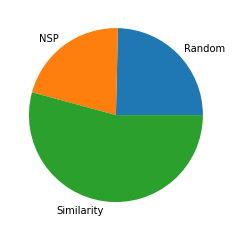

In [50]:
plt.pie(np.array(pair_matching_count[:-1]), labels = pair_matching_types)
plt.savefig(f'{export_path}pairs_matching.svg',bbox_inches='tight')
plt.show() 

### Label Distribution

In [51]:
df_distribution = pd.DataFrame([get_label_statistics(label)], columns=labels)
display(df_distribution)


,none,attribution,causal,conditional,contrast,description,equivalence,fulfillment,identity,purpose,summary,temporal
0,3172 (63.41%),23 (0.46%),434 (8.68%),56 (1.12%),165 (3.3%),53 (1.06%),340 (6.8%),43 (0.86%),80 (1.6%),22 (0.44%),24 (0.48%),590 (11.8%)


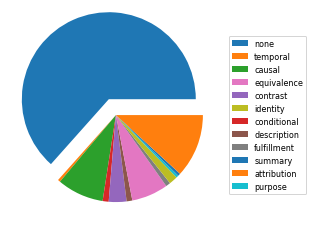

In [52]:
myexplode = [0] * len(labels)
myexplode[0] = 0.2
patches, texts = plt.pie(np.array(distribution_count), explode = myexplode)
# Sort Labels
patches, labels, dummy =  zip(*sorted(zip(patches, labels, np.array(distribution_count)),key=lambda x: x[2],reverse=True))
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(1., 0.5),fontsize=8)
plt.savefig(f'{export_path}pairs_distribution.svg',bbox_inches='tight')
plt.show() 

# Write Folds to disk

In [53]:
def create_df(origin, target, label):
    return pd.DataFrame(list(zip(origin, target, label)), columns=['origin', 'target', 'label'])

def export_dfs(k_fold_origin, k_fold_target, k_fold_labels):
    global export_path
    for i in range(len(k_fold_origin)):
        train_df = create_df(k_fold_origin[i][0], k_fold_target[i][0], k_fold_labels[i][0])
        test_df = create_df(k_fold_origin[i][1], k_fold_target[i][1], k_fold_labels[i][1])
        train_df.to_csv(f'{export_path}train.{i}.csv', index=False)
        test_df.to_csv(f'{export_path}test.{i}.csv', index=False)

In [54]:
export_dfs(k_fold_origin, k_fold_target, k_fold_labels)